## Import Packages

In [2]:
import helper_KNN as l
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import SCORERS
import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.neighbors import KNeighborsRegressor    # regressor
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline           # for making pipelines
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Import Data

In [3]:
#copy from the main file
import math
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
import matplotlib.pyplot as plt # plotting
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
import altair as alt
alt.renderers.enable('notebook')

df = pd.read_csv('./facebook_with_reactions.csv')
outcomes = df[['Rating']]

## drop useless columns 
df = df.drop(columns=['Debate', 'status_link', 'permalink_url', 'Post URL', 
                      'status_message', 'link_name', 'share_count', 'Unnamed: 0', 'account_id',
                      'status_id', 'status_type', 'status_published'])

## remove spaces in columns
df.columns = [c.replace(' ', '_') for c in df.columns]

## Create copy of data for modeling
model_data = df.copy()

## change Rating to numeric for classification
model_data.Rating = model_data.Rating.replace(['mostly false', 'no factual content', 'mixture of true and false', 'mostly true'], [0,1,2,3]).astype(int)
model_data = model_data.drop(columns=['post_id', 'reaction_count'])
#model_data = model_data.drop(columns=['Date_Published_2016-09-20','Date_Published_2016-09-21',
#                                     'Date_Published_2016-09-22','Date_Published_2016-09-23',
#                                     'Date_Published_2016-09-26','Date_Published_2016-09-27'])
## make dummy columns (make categories numeric)
model_data = pd.get_dummies(model_data)

In [4]:
model_data.describe()

,Rating,comment_count,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,...,Date_Published_2016-09-20,Date_Published_2016-09-21,Date_Published_2016-09-22,Date_Published_2016-09-23,Date_Published_2016-09-26,Date_Published_2016-09-27,Post_Type_link,Post_Type_photo,Post_Type_text,Post_Type_video
count,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,...,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000
mean,2.553555,441.455217,5296.478763,452.082179,3834.459834,4067.789935,262.443675,97.003232,439.513850,99.609418,...,0.138966,0.132041,0.128347,0.128809,0.179132,0.160203,0.770545,0.095106,0.001385,0.132964
std,0.837153,1324.224921,18159.453476,1510.787707,22345.925304,14940.861709,1397.449677,365.424746,2244.057024,544.522227,...,0.345991,0.338613,0.334553,0.335066,0.383551,0.366879,0.420580,0.293429,0.037199,0.339614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,34.000000,115.000000,29.000000,18.000000,78.000000,2.000000,2.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,3.000000,126.500000,480.000000,118.500000,76.000000,297.000000,13.000000,7.000000,20.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,386.000000,2211.500000,374.000000,556.000000,1466.250000,66.000000,42.000000,105.750000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,3.000000,32419.000000,330144.000000,35799.000000,401465.000000,280694.000000,37168.000000,10326.000000,53831.000000,11238.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df_target=model_data['Rating']
df_dropped=model_data
df_dropped=df_dropped.drop(columns=['Rating'])

## Null Values

In [6]:
#df.fillna(method='ffill', inplace=True)
df_dropped.fillna(method='ffill',inplace=True)

# Select Variables

In [15]:
import helper_KNN as l
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

<module 'helper_KNN' from 'C:\\Users\\jacob\\OneDrive\\Documents\\School\\INFO370\\Capstone\\INFO370FINAL\\helper_KNN.py'>

In [8]:
def feature_selection(data,target,original):
    X1,y1=data,target
    
    clf1=ExtraTreesClassifier(n_estimators=50) #can change
    
    clf1=clf1.fit(X1,y1)
    model1 = SelectFromModel(clf1, prefit=True)
    X1_new = model1.transform(X1)
    
    temp=list(data.columns.values)
    index=np.argsort(clf1.feature_importances_)
    result=[]
    for i in range(len(index)):
        result.append(temp[index[i]])

    df = pd.DataFrame({'r':result, 'index':index})
    df1 = df.loc[df['index']<5] #select based on how many variables you want
    final_list=list(df1['r'])
    print(final_list)
    df_selected=original[final_list] #this is the features
    
    return df_selected

In [14]:
clf1=ExtraTreesClassifier(n_estimators=10)
clf1=clf1.fit(df_dropped,df_target)
model1 = SelectFromModel(clf1, prefit=True)
clf1.feature_importances_

array([0.08203555, 0.06030268, 0.05684202, 0.08257461, 0.05689718,
       0.05020077, 0.0633285 , 0.05724145, 0.04486818, 0.05469607,
       0.01127764, 0.07891365, 0.02307233, 0.0079705 , 0.00345616,
       0.01020601, 0.0162426 , 0.00515662, 0.01311524, 0.00738195,
       0.00593057, 0.01233823, 0.01166156, 0.01178473, 0.0129845 ,
       0.01055366, 0.01572302, 0.01703996, 0.04228531, 0.06519412,
       0.00013342, 0.00859122])

In [13]:
list(model_data.columns.values)

['Rating',
 'comment_count',
 'num_reactions',
 'num_comments',
 'num_shares',
 'num_likes',
 'num_loves',
 'num_wows',
 'num_hahas',
 'num_sads',
 'num_angrys',
 'Category_left',
 'Category_mainstream',
 'Category_right',
 'Page_ABC News Politics',
 'Page_Addicting Info',
 'Page_CNN Politics',
 'Page_Eagle Rising',
 'Page_Occupy Democrats',
 'Page_Politico',
 'Page_Right Wing News',
 'Page_The Other 98%',
 'Date_Published_2016-09-19',
 'Date_Published_2016-09-20',
 'Date_Published_2016-09-21',
 'Date_Published_2016-09-22',
 'Date_Published_2016-09-23',
 'Date_Published_2016-09-26',
 'Date_Published_2016-09-27',
 'Post_Type_link',
 'Post_Type_photo',
 'Post_Type_text',
 'Post_Type_video']

In [7]:
df_selected_1=l.feature_selection(df_dropped,df_target,model_data)

['num_comments', 'num_reactions', 'num_likes', 'comment_count', 'num_shares']


In [8]:
df_dropped.describe()

,comment_count,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,...,Date_Published_2016-09-20,Date_Published_2016-09-21,Date_Published_2016-09-22,Date_Published_2016-09-23,Date_Published_2016-09-26,Date_Published_2016-09-27,Post_Type_link,Post_Type_photo,Post_Type_text,Post_Type_video
count,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,...,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000
mean,441.455217,5296.478763,452.082179,3834.459834,4067.789935,262.443675,97.003232,439.513850,99.609418,326.845337,...,0.138966,0.132041,0.128347,0.128809,0.179132,0.160203,0.770545,0.095106,0.001385,0.132964
std,1324.224921,18159.453476,1510.787707,22345.925304,14940.861709,1397.449677,365.424746,2244.057024,544.522227,1272.145380,...,0.345991,0.338613,0.334553,0.335066,0.383551,0.366879,0.420580,0.293429,0.037199,0.339614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,115.000000,29.000000,18.000000,78.000000,2.000000,2.000000,3.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,126.500000,480.000000,118.500000,76.000000,297.000000,13.000000,7.000000,20.000000,3.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,386.000000,2211.500000,374.000000,556.000000,1466.250000,66.000000,42.000000,105.750000,15.000000,106.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,32419.000000,330144.000000,35799.000000,401465.000000,280694.000000,37168.000000,10326.000000,53831.000000,11238.000000,26014.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split Data

In [9]:
#Split Data as training and test

#df_selected=selecting the ideal cols

#df_target=with the outcome

train_features,test_features,train_outcome,test_outcome=train_test_split(
    df_selected_1,
    df_target,
    test_size=0.20,
    random_state=11,
)

In [10]:
df_dropped.describe()

,comment_count,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,...,Date_Published_2016-09-20,Date_Published_2016-09-21,Date_Published_2016-09-22,Date_Published_2016-09-23,Date_Published_2016-09-26,Date_Published_2016-09-27,Post_Type_link,Post_Type_photo,Post_Type_text,Post_Type_video
count,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,...,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000
mean,441.455217,5296.478763,452.082179,3834.459834,4067.789935,262.443675,97.003232,439.513850,99.609418,326.845337,...,0.138966,0.132041,0.128347,0.128809,0.179132,0.160203,0.770545,0.095106,0.001385,0.132964
std,1324.224921,18159.453476,1510.787707,22345.925304,14940.861709,1397.449677,365.424746,2244.057024,544.522227,1272.145380,...,0.345991,0.338613,0.334553,0.335066,0.383551,0.366879,0.420580,0.293429,0.037199,0.339614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,115.000000,29.000000,18.000000,78.000000,2.000000,2.000000,3.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,126.500000,480.000000,118.500000,76.000000,297.000000,13.000000,7.000000,20.000000,3.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,386.000000,2211.500000,374.000000,556.000000,1466.250000,66.000000,42.000000,105.750000,15.000000,106.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,32419.000000,330144.000000,35799.000000,401465.000000,280694.000000,37168.000000,10326.000000,53831.000000,11238.000000,26014.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Grid Search

{'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 9}


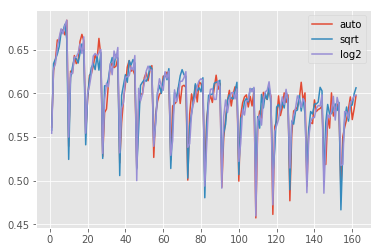

In [11]:
#dropped is the dataframe with numeric values
#selected is the one with all the selected variables

#l.model_selection_random_forest(df_dropped,df_target,train_features,train_outcome)
l.model_selection_random_forest(df_selected_1,df_target,train_features,train_outcome)

## Model Fitting

In [12]:
#fill in all the best parameters
#w=50
#best_model_1=RandomForestClassifier(bootstrap='true',max_features='auto',min_samples_split=75,n_estimators=8,class_weight={0: 1, 1: w,2:w,3:w})
#best_model_1.fit(train_features,train_outcome)
#79.7


best_model_1=RandomForestClassifier(bootstrap='true',max_features='auto',min_samples_split=10,n_estimators=9,class_weight={0: 20, 1: 6,2:6,3:1})
best_model_1.fit(train_features,train_outcome)

RandomForestClassifier(bootstrap='true',
            class_weight={0: 20, 1: 6, 2: 6, 3: 1}, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
#n_samples=model_data.shape[0]
#n_classes=
#n_samples / (n_classes * np.bincount(y))

## MAE

In [14]:
l.get_MAE(best_model_1,train_features,test_features,train_outcome,test_outcome)

0.4308755760368664

## Graphs

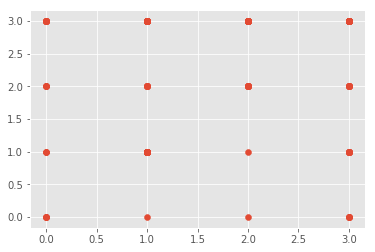

In [15]:
plt.scatter(best_model_1.predict(test_features),test_outcome)

## Cross Validation

In [16]:
l.cross_val(test_features,test_outcome,best_model_1)

0.7049154334038056

In [17]:
accuracy_score(test_outcome, best_model_1.predict(test_features))

0.7442396313364056

In [18]:
best_model_1.predict(test_features)

array([3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 2, 0, 2, 3, 3, 3, 3,
       3, 3, 1, 3, 2, 1, 3, 3, 3, 2, 0, 3, 1, 3, 0, 3, 3, 0, 3, 3, 1, 1,
       3, 0, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 2, 3, 3, 2,
       1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 1, 3, 3, 2, 2, 3, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3,
       3, 3, 1, 3, 0, 2, 1, 1, 3, 3, 3, 2, 3, 1, 3, 3, 2, 3, 3, 3, 0, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 0, 3, 0, 1, 3, 0, 3,
       3, 3, 2, 1, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 1, 2, 3, 1, 3, 0, 3, 1, 1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 1, 1, 3, 0, 2, 1, 1, 3, 1, 3, 3, 0, 0,

In [20]:
from sklearn.metrics import confusion_matrix
y_pred=best_model_1.predict(test_features)
confusion_matrix(test_outcome, y_pred)

array([[  5,   1,   1,   6],
       [  3,  33,   1,  12],
       [  5,   9,  13,  11],
       [ 12,  22,  28, 272]])

In [23]:
#n_samples / (n_classes * np.bincount(y))
from sklearn.metrics import f1_score
f1_score(test_outcome, y_pred,average="weighted")

0.7606507779245949